In [24]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage
from tqdm import tqdm
import time
import cv2
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim

import torchvision
from torchvision.datasets import MNIST

In [87]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()

        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed

In [156]:
# /content/drive/MyDrive/UMDCP/CMSC/CMSC472/JohnOliver1-cropped-face-crop
class AEDataset(Dataset):
    def __init__(self, file_path):
        self.file_path = file_path
      
        temp = []

        for filename in os.listdir(file_path)[:600]:
            if filename.endswith(".jpg"):
                img = cv2.imread(file_path + '/'+filename)
                img = cv2.resize(img,(128,128))
                grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                (thresh, blackAndWhiteImage) = cv2.threshold(grayImage, 127, 255, cv2.THRESH_BINARY)

                temp.append(blackAndWhiteImage)
                if(temp is None): print("NONE")
        print(len(temp))
        self.x = torch.tensor(temp,dtype=torch.float32)
        print(type(self.x[0]))
        self.x = torch.flatten(self.x,1)

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        ## return image, and, if not test mode, the label at the given index
        ## valid formats include:
        ## {'image': image, 'label': label}
        ## image, label
        ## where image and label have both been converted to torch.Tensors
        image = self.x[idx].clone().detach()
        return image


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [158]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=128*128).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

epochs = 40

In [159]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_dataset = AEDataset('/content/drive/MyDrive/UMDCP/CMSC/CMSC472/JohnOliver1-cropped-face-crop')
# train_dataset = MNIST(
#     root="~/torch_datasets", train=True, transform=transform, download=True
# )
# /content/drive/MyDrive/UMDCP/CMSC/CMSC472/JimmyF
test_dataset = AEDataset('/content/drive/MyDrive/UMDCP/CMSC/CMSC472/JimmyF')
# test_dataset = MNIST(
#     root="~/torch_datasets", train=False, transform=transform, download=True
# )
print(len(train_dataset))
train_loader = torch.utils.data.DataLoader(
    train_dataset,batch_size=20, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False, num_workers=4
)
print(type(train_dataset.__getitem__(0)))

600
<class 'torch.Tensor'>
1
<class 'torch.Tensor'>
600
<class 'torch.Tensor'>


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [160]:
for epoch in range(epochs):
    loss = 0
    for idx, batch_features in enumerate(train_loader):
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        # batch_features = batch_features.view(-1, 163840).to(device)
        batch_features = batch_features.cuda()
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumultrain_loaderated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch : 1/40, loss = 21919.356608
epoch : 2/40, loss = 15839.134115
epoch : 3/40, loss = 15064.003483
epoch : 4/40, loss = 13850.507031
epoch : 5/40, loss = 13100.928971
epoch : 6/40, loss = 12207.463672
epoch : 7/40, loss = 11328.792969
epoch : 8/40, loss = 10757.460124
epoch : 9/40, loss = 10175.711849
epoch : 10/40, loss = 9662.447233
epoch : 11/40, loss = 9147.554883
epoch : 12/40, loss = 8787.640918
epoch : 13/40, loss = 8508.261686
epoch : 14/40, loss = 8226.928206
epoch : 15/40, loss = 7987.127669
epoch : 16/40, loss = 7811.405632
epoch : 17/40, loss = 7680.819792
epoch : 18/40, loss = 7564.633496
epoch : 19/40, loss = 7433.602881
epoch : 20/40, loss = 7329.328776
epoch : 21/40, loss = 7229.908919
epoch : 22/40, loss = 7145.990479
epoch : 23/40, loss = 7059.654720
epoch : 24/40, loss = 6979.522933
epoch : 25/40, loss = 6903.727637
epoch : 26/40, loss = 6837.691195
epoch : 27/40, loss = 6766.562207
epoch : 28/40, loss = 6684.055420
epoch : 29/40, loss = 6616.920166
epoch : 30/40,

In [161]:
test_examples = None

with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features.cuda()
        test_examples = batch_features.view(-1, 128*128).cuda()
        reconstruction = model(batch_features).cpu()
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


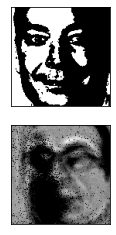

In [162]:
with torch.no_grad():
    number = 1
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].cpu().detach().numpy().reshape(128, 128))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index].numpy().reshape(128, 128))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()